In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

### Customer Dataset

In [2]:
f = "../assignment-2-ksr-0011/Data/SMAI-Dataset-customer-dataset/data.csv"
raw_data = pd.read_csv(f)
raw_data.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1


In [3]:
data = np.array(raw_data.iloc[:, 1:])

In [4]:
data.shape

(2000, 7)

## GMM Class Implementation

In [5]:
def GaussianProbs(X, mean, covariance):
    E = 1e-5

    probs = np.zeros(X.shape[0])
    covariance = np.diag(E+np.diag(covariance))

    for i in range(X.shape[0]):
        x = X[i, :]
        x_c = x-mean
        l = (1 / np.sqrt(np.linalg.det(covariance))) * np.exp(-0.5 * np.dot(np.dot((x_c), np.linalg.inv(covariance)), (x_c).T))
        probs[i] = l

    return probs

In [6]:
# GMM class implementation

class GMM():
    def __init__(self, k = 10,max_iters = 20):
        self.k = k  
        self.means = None
        self.covs = None
        self.pi = None
        self.likelihoods = None
        self.max_iters = max_iters

    def init_params(self, X):
        n_feature = X.shape[1]

        # Randomly initialize means, covariances and probabilities
        # self.means = np.random.rand(self.k, n_feature)
        # self.covs = np.random.rand(self.k, n_feature)
        # self.pi = np.random.rand(self.k)
        # self.pi = self.pi / np.sum(self.pi)

        # Initializing using K-means
        kmeans = KMeans(n_clusters=self.k, random_state=42).fit(X)
        self.means = kmeans.cluster_centers_
        self.covs = np.zeros((self.k, n_feature))
        self.pi = np.ones(self.k)
        self.pi = self.pi / np.sum(self.pi)
        # For covariance writing a code such that it is initialized using covariance of points in a cluster with its mean
        for i in range(self.k):
            cluster = X[kmeans.labels_ == i]
            cluster_cov = np.cov(cluster.T)
            self.covs[i] = cluster_cov.diagonal()
            


    def compute_likelihood(self, X):
        likelihoods = np.zeros((self.k, X.shape[0]))

        for i in range(self.k):
            likelihoods[i] = self.pi[i]*GaussianProbs(X, self.means[i], np.diag(self.covs[i]))

        # E = 1e-10
        likelihoods = likelihoods/(np.sum(likelihoods, axis=0))

        self.likelihoods = likelihoods    

    def update_params(self, X):
        means = np.zeros((self.k, X.shape[1]))
        covs = np.zeros((self.k, X.shape[1]))
        pi = np.zeros(self.k)
        for i in range(self.k):
            pi[i] = np.sum(self.likelihoods[:, i])/X.shape[0]
            # E = 1e-10
            pi = pi/(np.sum(pi))
            X_c = X - self.means[i]
            for datapt in range(X.shape[0]):
                means[i] += self.likelihoods[i][datapt]*X[datapt]
                covs[i] += self.likelihoods[i][datapt]*((X_c[datapt].T).dot(X_c[datapt]))
            means[i] /= (np.sum(self.likelihoods[i]))
            covs[i] /= (np.sum(self.likelihoods[i]))

        self.means = means
        self.covs = covs
        self.pi = pi

    def predict(self, X):
        probs = np.zeros((self.k, X.shape[0]))
        for i in range(self.k):
            probs[i] = self.pi[i]*GaussianProbs(X, self.means[i], np.diag(self.covs[i]))
        return np.argmax(probs, axis=0)  
    
    def fit(self, X):
        self.init_params(X)
        for i in range(self.max_iters):
            self.compute_likelihood(X)
            self.update_params(X)

    def obtain_params(self):
        return self.means, self.covs, self.pi
    
    def get_likelihood(self, X):
        likelihoods = np.zeros((self.k, X.shape[0]))

        for i in range(self.k):
            likelihoods[i] = self.pi[i]*GaussianProbs(X, self.means[i], np.diag(self.covs[i]))

        likelihoods/=np.sum(likelihoods, axis=0)

        return likelihoods
    
    def log_likelihood(self, X):
        likelihoods = np.zeros((self.k, X.shape[0]))

        for i in range(self.k):
            likelihoods[i] = self.pi[i]*GaussianProbs(X, self.means[i], np.diag(self.covs[i]))

        likelihoods = np.sum(likelihoods, axis=0)
        return np.sum(np.log(likelihoods))
    
    def get_membership(self, X):
        g = np.zeros((self.k, X.shape[0]))
        for i in range(self.k):
            prob_i = GaussianProbs(X, self.means[i], self.covs[i])
            for j in range(X.shape[0]):
                g[i][j] = self.pi[i]*prob_i[j]
                
        g /= np.sum(g, axis=0)
        return g            



In [7]:
GMM_model = GMM(k=10, max_iters=20)
GMM_model.fit(data)
means, covs, pi = GMM_model.obtain_params()


In [8]:
print(means)

[[3.67940183e-01 4.65764026e-01 3.90539258e+01 1.14078513e+00
  1.43022472e+05 1.11217027e+00 1.05443615e+00]
 [5.15665061e-01 4.76843246e-01 3.19224495e+01 8.40467738e-01
  7.27717955e+04 2.42360264e-02 4.31817785e-02]
 [2.28112463e-01 3.47930090e-01 4.17780821e+01 1.14256301e+00
  2.18931752e+05 1.76257835e+00 1.48924295e+00]
 [5.58961146e-01 5.34996258e-01 3.26318964e+01 9.50851550e-01
  8.97960805e+04 3.30893360e-01 2.97262296e-01]
 [3.57713053e-01 4.61645819e-01 4.99065432e+01 1.62425474e+00
  2.77559536e+05 1.91190432e+00 1.64234180e+00]
 [2.87713544e-01 4.28563951e-01 5.19598766e+01 1.75527466e+00
  2.79266671e+05 1.91885411e+00 1.64656690e+00]
 [4.45743291e-01 4.77847133e-01 3.67685430e+01 1.06018605e+00
  1.22845190e+05 8.79804878e-01 8.17190922e-01]
 [2.56080651e-01 3.48821585e-01 4.69029535e+01 1.47283071e+00
  2.66133388e+05 1.87209614e+00 1.62155348e+00]
 [5.53686795e-01 5.63640882e-01 3.23577093e+01 9.50966306e-01
  1.05787565e+05 7.39625622e-01 6.03640405e-01]
 [6.999827

### Wine Dataset

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_wine

In [10]:
data = load_wine()
X = data.data
y = data.target

In [11]:
def aic(X, model):
    loglikelihood = model.log_likelihood(X)
    n_params = model.k*(2*X.shape[1]+1)    
    return 2*n_params - 2*loglikelihood

def bic(X, model):
    loglikelihood = model.log_likelihood(X)
    n_params = model.k*(2*X.shape[1]+1)    
    return np.log(X.shape[0])*n_params - 2*loglikelihood

aic_scores = []
bic_scores = []
for k in range(1, 10):
    model = GMM(k, 50)
    model.fit(X)
    aic_scores.append(aic(X, model))
    bic_scores.append(bic(X, model))

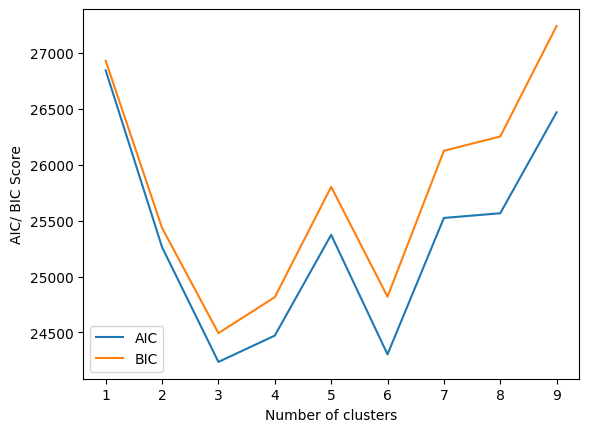

In [48]:
plt.figure()
plt.plot(range(1, 10), aic_scores, label='AIC')
plt.plot(range(1, 10), bic_scores, label='BIC')
plt.xlabel('Number of clusters')
plt.ylabel('AIC/ BIC Score')
plt.legend()

We can see that both AIC and BIC values are lowest for 3 clusters. 
This is consistent with the number of classes in the dataset.

### Clustering with PCA

c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


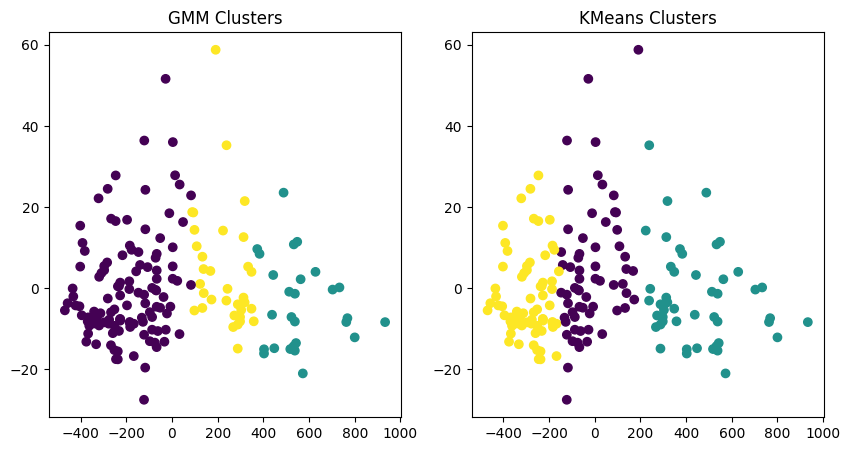

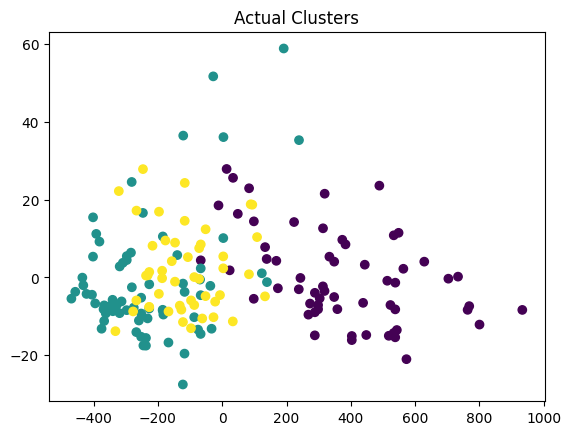

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
y = data.target

GMM_model = GMM(k = 3, max_iters=20)
GMM_model.fit(X_pca)
y_pred_gmm = GMM_model.predict(X_pca)

Kmeans_model = KMeans(n_clusters = 3)
Kmeans_model.fit(X_pca)
y_pred_kmeans = Kmeans_model.predict(X_pca)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_gmm)
plt.title('GMM Clusters')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans)
plt.title('KMeans Clusters')
plt.show()
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('Actual Clusters')
plt.show()

The result of my GMM and KMeans implementation are very similar.

#### Silhouette Score

In [79]:
from sklearn.metrics import silhouette_score
gmm_score = silhouette_score(X_pca, y_pred_gmm)
kmeans_score = silhouette_score(X_pca, y_pred_kmeans)

print("Silhouette Score for GMM: ", gmm_score)
print("Silhouette Score for KMeans: ", kmeans_score)

Silhouette Score for GMM:  0.5660974090818679
Silhouette Score for KMeans:  0.5722554756855064
